# Visualisasi Ekstraksi Fitur

In [18]:
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from skimage.feature import hog

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

from src.configs.config import DATA_RAW_PATH, CLASSES
from src.preprocessing.image_preprocessing import preprocess_image_for_feature_extraction
from src.features.feature_extraction import extract_hog_features, extract_color_histogram, extract_lbp_features, extract_gabor_features, extract_features
from src.utils.dataset_loader import load_images_from_folder

## Gambar Sampel

2025-10-06 01:06:17,672 - INFO - dataset_loader - Memuat gambar asli dari 'd:\CODE\python-project\klasifikasi-cuaca-svm\svm\data\raw'...
Loading Berkabut (Foggy): 100%|██████████| 300/300 [00:00<00:00, 313.17it/s]
2025-10-06 01:06:21,166 - INFO - dataset_loader - Total gambar asli yang berhasil dimuat: 1200


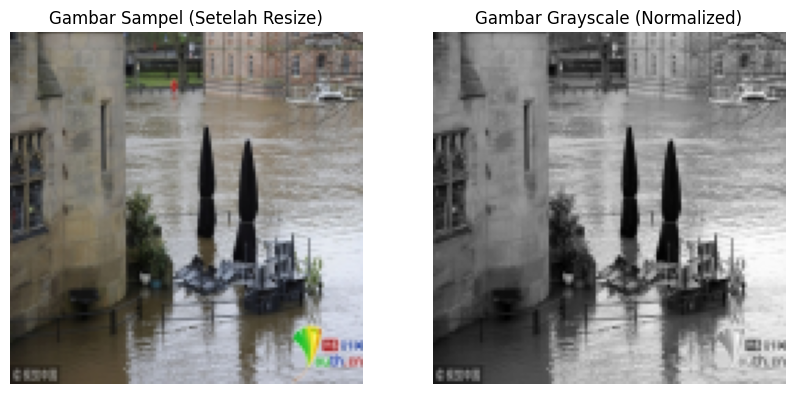

In [19]:
images, _, _ = load_images_from_folder(DATA_RAW_PATH)
sample_image = random.choice(images)

normalized_gray, normalized_color, resized_uint8 = preprocess_image_for_feature_extraction(sample_image)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(cv2.cvtColor(resized_uint8, cv2.COLOR_BGR2RGB))
axes[0].set_title('Gambar Sampel (Setelah Resize)')
axes[0].axis('off')

axes[1].imshow(normalized_gray, cmap='gray')
axes[1].set_title('Gambar Grayscale (Normalized)')
axes[1].axis('off')

plt.show()

## Visualisasi Fitur HOG (Histogram of Oriented Gradients)

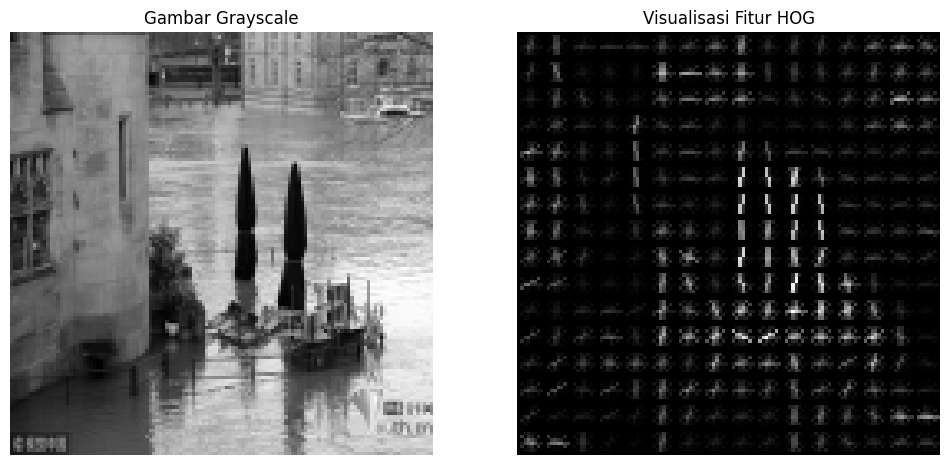

Ukuran vektor fitur HOG: (8100,)


In [20]:
from src.configs.config import HOG_ORIENTATIONS, HOG_PIXELS_PER_CELL, HOG_CELLS_PER_BLOCK

hog_feats, hog_image = hog(
    normalized_gray,
    orientations=HOG_ORIENTATIONS,
    pixels_per_cell=HOG_PIXELS_PER_CELL,
    cells_per_block=HOG_CELLS_PER_BLOCK,
    block_norm='L2-Hys',
    visualize=True,
    transform_sqrt=True
)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(normalized_gray, cmap='gray')
axes[0].set_title('Gambar Grayscale')
axes[0].axis('off')

axes[1].imshow(hog_image, cmap='gray')
axes[1].set_title('Visualisasi Fitur HOG')
axes[1].axis('off')

plt.show()

print(f"Ukuran vektor fitur HOG: {hog_feats.shape}")

## Visualisasi Fitur Color Histogram

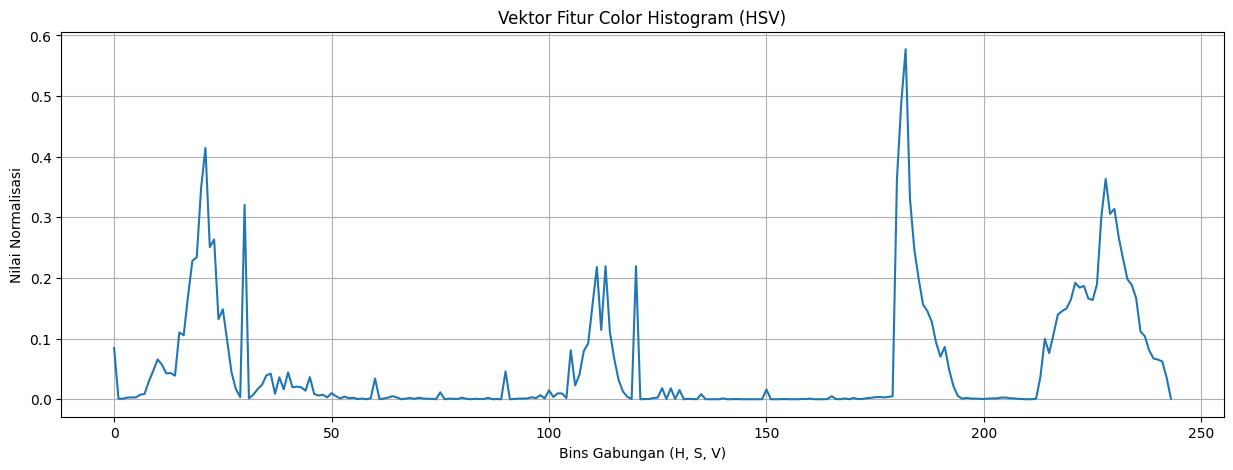

Ukuran vektor fitur Color Histogram: (244,)


In [21]:
color_hist_feats = extract_color_histogram(normalized_color)

plt.figure(figsize=(15, 5))
plt.plot(color_hist_feats)
plt.title('Vektor Fitur Color Histogram (HSV)')
plt.xlabel('Bins Gabungan (H, S, V)')
plt.ylabel('Nilai Normalisasi')
plt.grid(True)
plt.show()

print(f"Ukuran vektor fitur Color Histogram: {color_hist_feats.shape}")

## Visualisasi Fitur LBP (Local Binary Patterns)

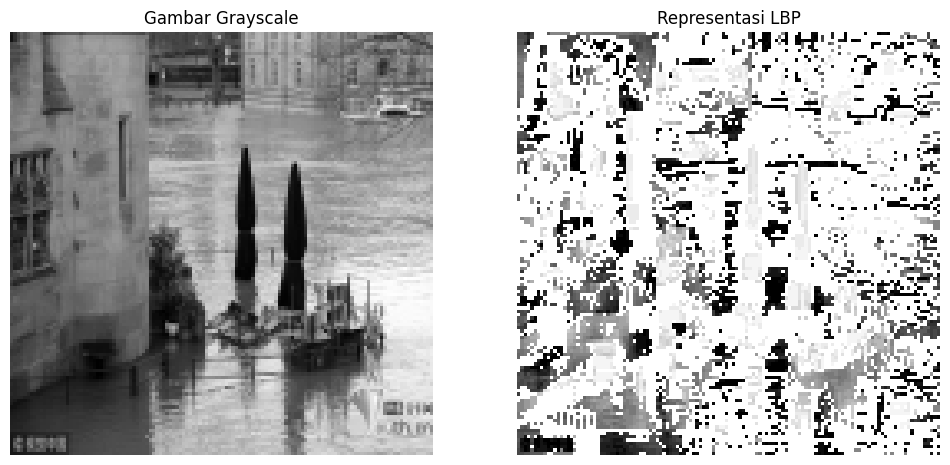

Ukuran vektor fitur LBP (setelah histogram): (26,)


In [22]:
from skimage.feature import local_binary_pattern

radius = 8
n_points = 24
gray_image_uint8 = (normalized_gray * 255).astype(np.uint8)
lbp_image = local_binary_pattern(gray_image_uint8, n_points, radius, method='uniform')
lbp_feats = extract_lbp_features(normalized_gray)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(normalized_gray, cmap='gray')
axes[0].set_title('Gambar Grayscale')
axes[0].axis('off')

axes[1].imshow(lbp_image, cmap='gray')
axes[1].set_title('Representasi LBP')
axes[1].axis('off')

plt.show()

print(f"Ukuran vektor fitur LBP (setelah histogram): {lbp_feats.shape}")

## Visualisasi Fitur Gabor Filters

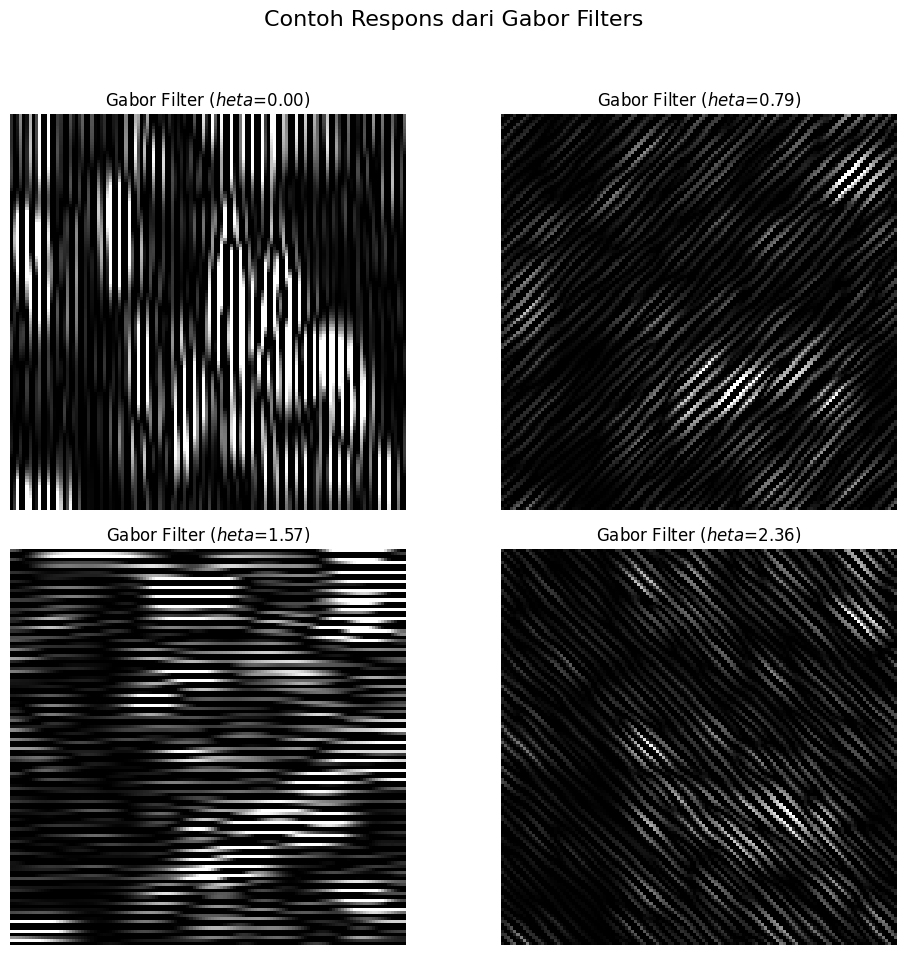

Ukuran vektor fitur Gabor (mean & std dev): (48,)


In [23]:
gabor_feats = extract_gabor_features(normalized_gray)

ksize = 31
filters_for_viz = []
orientations_for_viz = [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4]

for theta in orientations_for_viz:
    kernel = cv2.getGaborKernel((ksize, ksize), sigma=3.0, theta=theta, lambd=np.pi, gamma=0.5, psi=0, ktype=cv2.CV_32F)
    filters_for_viz.append(kernel)

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
img_for_viz = (normalized_gray * 255).astype(np.uint8)

for i, (ax, kernel) in enumerate(zip(axes.flatten(), filters_for_viz)):
    filtered_img = cv2.filter2D(img_for_viz, cv2.CV_8UC3, kernel)
    ax.imshow(filtered_img, cmap='gray')
    ax.set_title(f'Gabor Filter ($\theta$={orientations_for_viz[i]:.2f})')
    ax.axis('off')

plt.suptitle('Contoh Respons dari Gabor Filters', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print(f"Ukuran vektor fitur Gabor (mean & std dev): {gabor_feats.shape}")

## Menggabungkan Semua Fitur

In [24]:
combined_features = extract_features(normalized_gray, normalized_color)

print(f"Ukuran HOG: {hog_feats.shape[0]}")
print(f"Ukuran Color Histogram: {color_hist_feats.shape[0]}")
print(f"Ukuran LBP: {lbp_feats.shape[0]}")
print(f"Ukuran Gabor: {gabor_feats.shape[0]}")
print("-----")
print(f"Ukuran Vektor Fitur Gabungan: {combined_features.shape}")

Ukuran HOG: 8100
Ukuran Color Histogram: 244
Ukuran LBP: 26
Ukuran Gabor: 48
-----
Ukuran Vektor Fitur Gabungan: (8418,)
